In [1]:
! pip install spacy
! python -m spacy download en
! pip install wordcloud
! wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/sentiment.tsv


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

--2019-04-15 10:12:15--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/sentiment.tsv
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447540 (437K) [text/plain]
Saving to: ‘sentiment.tsv’

sentiment.tsv       100%[===================>] 437.05K   946KB/s    in 0.5s    

2019-04-15 10:12:16 (946 KB/s) - ‘sentiment.tsv’ saved [447540/447540]



# Task: sentiment classification

The task is to classify one-sentence long movie reviews/opinions according to the sentiment they express. There are only two categories: positive and negative sentiment.


> "Data source: [UMICH SI650 - Sentiment Classification](https://www.kaggle.com/c/si650winter11/data)

> Training data: 7086 lines. 
  
> Format: 1|0 (tab) sentence

> Test data: 33052 lines, each contains one sentence. 

> The data was originally collected from opinmind.com (which is no longer active)."

The data is in the file "sentiment.tsv".

# Loading the data

In [2]:
import pandas as pd

df = pd.read_csv('sentiment.tsv', sep='\t', 
                 quoting=3, # Quotes are _never_ field separators
                 header=None)

df.head()

,0,1
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


In [3]:
df = df[[1,0]] # reorder columns

df.rename(columns={1:"text", 0:"sentiment"}, inplace=True) # rename columns

df.head()

,text,sentiment
0,The Da Vinci Code book is just awesome.,1
1,this was the first clive cussler i've ever rea...,1
2,i liked the Da Vinci Code a lot.,1
3,i liked the Da Vinci Code a lot.,1
4,I liked the Da Vinci Code but it ultimatly did...,1


# Splitting into train, validation and test

Before doing anything else (!) we divide our data into train, validation and test parts,

In [4]:
# Import from Scikit the relevant function for splitting training and testing data

from sklearn.model_selection import train_test_split

# We know that it can only split into two parts at once, so it is advisable
# to repeat the splitting two times in a after each-other.
# Please fix the random seed to 13, since it is said to be lucky+ :-P
df_train, df_test_valid = train_test_split(df,test_size=0.20, random_state=13)

df_test, df_valid = train_test_split(df_test_valid,test_size=0.50, random_state=13)

assert len(df_train)==5668 and len(df_valid)==709 and len(df_test)==709
print(len(df_train), len(df_valid), len(df_test))

5668 709 709


# Inspecting the data

In [5]:
df_train.describe()

,sentiment
count,5668.000000
mean,0.559104
std,0.496538
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


We can examine the lengths of sentences as well.

In [6]:
n_chars = df_train.text.apply(lambda x: len(x))

n_chars.describe()

count    5668.000000
mean       60.100565
std        37.931478
min        18.000000
25%        32.000000
50%        48.000000
75%        77.000000
max       203.000000
Name: text, dtype: float64

The first sentence with the maximal length:

In [7]:
long_sentence = df_train.loc[n_chars.idxmax(), "text"]
long_sentence

'A mother in Georgia wants her local school board to take Harry Potter out of the schools and libraries because, in her opinion, reading Harry Potter leads to witchcraft, which according to her is evil...'

# Extra task: Let's do a word cloud!

Let us visualize together and separately (by category) the sentences!

Tool: https://github.com/amueller/word_cloud


Good example: https://github.com/amueller/word_cloud/blob/master/examples/simple.py

In [0]:
# Helper function for displaying a word cloud
# Input: one _UNIFIED_, space separated string!
# Protip: https://www.tutorialspoint.com/python/string_join.htm
def do_wordcloud(text):
    from wordcloud import WordCloud
    
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt

    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


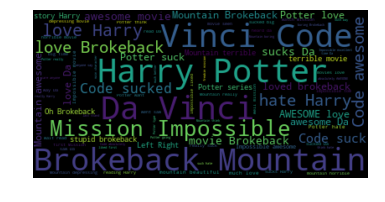

In [9]:
### TASK !!! ####
#Put here the world cloud!
s = " "
do_wordcloud(s.join(df.text))


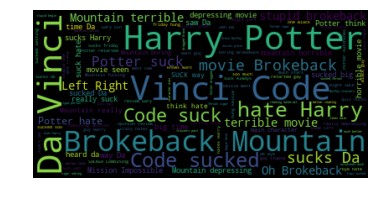

In [25]:
### TASK !!! ####
# Here only the cloud for sentences with negative sentiment!
# Help: the shape of the DataFrame with only the negative sentences is: (2975, 2)
# Source: https://pandas.pydata.org/pandas-docs/stable/indexing.html

s = " "
df_negative = df.text.loc[df['sentiment'] == 0]
do_wordcloud(s.join(df_negative))

# Bag of words (BoW) representation of the texts

We will represent each text as a (sparse) vector of lemma (word root) counts for frequent lemmas in the training data.

For tokenization and lemmatization we use spaCy, an open source Python NLP library, which can produce a list of unique lemma ids from the text.

In [0]:
import spacy

nlp = spacy.load("en", disable=["parser", "ner"]) # We need only the tokenizer

spaCy can produce spaCy Doc objects from texts that contain their linguistic analysis, among others lemmas and their unique spaCy string ids.

In [0]:
doc = nlp(long_sentence)

type(doc)

spacy.tokens.doc.Doc

print([token.lemma_ for token in doc ]) # Lemmas

In [0]:
print([token.lemma for token in doc]) # Corresponding unique ids

Now we have to convert these lists into BoW vectors. We could "roll our own", but, fortunately, scikit-learn has a feature extractor doing exactly that, the CountVectorizer so, for the sake of simplicity, we will use that along with spaCy.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer=lambda s: [token.lemma for token in nlp(s)], # use spaCy for analysis

                     min_df= 0.001) # Ignore lemmas with lower document frequency

cv

In [0]:
sents = ["I hate this movie.", "The movie is the worst I've seen."]

bows = cv.fit_transform(sents).toarray() 
# CountVectorizer produces a sparse matrix so we convert to ndarray

bows

array([[1, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 2, 0, 1, 1, 1, 1, 1, 1]], dtype=int64)

Using the CountVectorizer we convert the text columns of our train, validation and test data into three sparse matrices.

In [0]:
bows_train = cv.fit_transform(df_train.text)
bow_length = bows_train.shape[1]
print("BoW length:", bow_length)
bows_train

In [0]:
bows_valid = cv.transform(df_valid.text)
bows_test = cv.transform(df_test.text)

# The model

We build a simple feedforward binary classifier in Keras, which will be trained using a crossentropy loss. (Could be using one-dimensional output with, say, log loss, but we go with the general classification "design pattern".)

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import clear_session

tf.reset_default_graph() # It's good practice to clear and reset everything
clear_session            # even using Keras


# WE USE KERAS FUNCTIONAL API!!!


# Parameters
############

hidden_size = 100

# Model
#######
# Define (instantiate) the input layer!
# Give it as shape parameter the length of the BoW representation as vector 
# (we have a variable for that)
# observe, the shape _ONLY ACCEPTS A TUPLE WITH ONE ELEMENT!!!
inputs = Input(shape=(bow_length,))

# Hidden layer
##############
# Define a fully connected hidden layer,which uses the above set parameters for size 
# (number of neurons)
# Use the ReLU activation function.
# The input of the layer should come from inputs.
# Please observe, that the functional API of Keras accepts the layer parameters as
# the ones defining the function, wheras the input for the thus created function is 
# used in the "call".
# Think about it, the magic lies in the brackets! :-)
hidden_output = Dense(hidden_size, activation = 'relu')(inputs)


# Softmax 
#########
# DEfine the ouput Softmax layer!
# (Which is a fully connected layer with a special activation...)
# Remember, how many target classes we have!
# Feed this layer with the output of the hidden one...
predictions = Dense(2,activation = 'softmax')(hidden_output)

# Optimizer
##############
# Now we go for a simple solution.
optimizer = SGD(lr=0.1)

# Full model
##############
# Nothing more to do, but to create a real model instance.
# Please take care that inputs and outputs are correct!
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Now we can specify the optimizer and loss, and compile the modell:

In [0]:
# Compilation 
#########################

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', # we use this cross entropy variant 
                                                      # as the input is not 
                                                      # one-hot encoded
              metrics=['accuracy']) # We save only this metric through training.

# Training

In [0]:
history = model.fit(x=bows_train, 
              y=df_train.sentiment.values,
              validation_data=(bows_valid, df_valid.sentiment.values),
              epochs=10,
              batch_size=200)

In [0]:
from matplotlib import pyplot as plt

def display_history(history):
    """Summarize history for accuracy and loss.
    """
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
display_history(history);

In [0]:
assert max(history.history['acc'])>0.975
assert max(history.history['val_acc'])>0.965

# Prediction

In [0]:
print("=== INTERACTIVE DEMO ===")
while True:
    s = input("Enter a short text to evaluate or press return to quit: ")
    if s == "":
        break
    else:
        bow = cv.transform([s])
        prob_pred = model.predict(bow[0])
        print(f"Positive vs negative sentiment probability: {prob_pred[0,1]} vs {prob_pred[0,0]}")